### IMPORTS

In [1]:
# manipulate data
import numpy as np
import pandas as pd

# statistical tests
import scipy as sp

# visualize data
import matplotlib.pyplot as plt
import seaborn as sn

# model preparation
from sklearn.model_selection import (train_test_split, learning_curve,
                                     LearningCurveDisplay, validation_curve,
                                     ValidationCurveDisplay)
from sklearn.preprocessing import StandardScaler

# pytorch
import torch as pt

# machine learning models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# model evaluation
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                            RocCurveDisplay, accuracy_score, f1_score,
                            precision_score, recall_score)

np.random.seed(123)
pd.options.display.max_columns = 100

### Load and Preprocess: Cardiovascular Disease

In [2]:
file1 = "cardio_data_processed.csv"
cardio_vasc = pd.read_csv(file1)

In [3]:
# id: just an index
# useing age_years over age
# using weight and height instead of bmi
# using ap_hi/lo instead of bp_category and bp_category_encoded
cardio_cols_drop = ['id', 'age', 'bmi', 'bp_category', 'bp_category_encoded']
cardio_vasc = cardio_vasc.drop(columns=cardio_cols_drop, axis=1)

In [4]:
cols_convert = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
cardio_vasc[cols_convert] = cardio_vasc[cols_convert].astype('category')

In [5]:
cardio_vasc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   gender       68205 non-null  category
 1   height       68205 non-null  int64   
 2   weight       68205 non-null  float64 
 3   ap_hi        68205 non-null  int64   
 4   ap_lo        68205 non-null  int64   
 5   cholesterol  68205 non-null  category
 6   gluc         68205 non-null  category
 7   smoke        68205 non-null  category
 8   alco         68205 non-null  category
 9   active       68205 non-null  category
 10  cardio       68205 non-null  category
 11  age_years    68205 non-null  int64   
dtypes: category(7), float64(1), int64(4)
memory usage: 3.1 MB


In [6]:
cardio_vasc.head(3)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,156,85.0,140,90,3,1,0,0,1,1,55
2,1,165,64.0,130,70,3,1,0,0,0,1,51


In [7]:
# split data
cd_train, cd_test = train_test_split(cardio_vasc, test_size=.15,
                                     random_state=123, stratify=cardio_vasc['cardio'])

# get X, y
target_col="cardio"
cols_drop=["cardio"]
X_train_cd = cd_train.drop(cols_drop, axis=1)
X_test_cd = cd_test.drop(cols_drop, axis=1)
y_train_cd = cd_train[target_col]
y_test_cd = cd_test[target_col]

### Load and Preprocess: Nutrition Facts

In [8]:
file2 = "MyFoodData_Nutrition_Facts_SpreadSheet_Release_1.4.xlsx"
nutrition_facts = pd.read_excel(file2)

In [9]:
nutrition_facts = nutrition_facts.dropna(axis=0, subset=["Food Group"])

# dropping columns that have every value missing
cols_drop = ["Added Sugar g", "Soluble Fiber g", "Insoluble Fiber g",
             "Total sugar alcohols g", "Molybdenum mcg", "Chlorine mg",
             "Biotin B7 mcg", "NetCarbs g"]
nutrition_facts = nutrition_facts.drop(columns=cols_drop, axis=1)

# dropping cols that don't seem to mean much
more_drop = ["PRAL score", "ID", "Name", '183 n3 ccc ALA mg',
             '205 n3 EPA mg', '225 n3 DPA mg', '226 n3 DHA mg',
             "Serving Weight 1 g", "Serving Weight 2 g", "Serving Weight 3 g",
             "Serving Weight 4 g", "Serving Weight 5 g", "Serving Weight 6 g",
             "Serving Weight 7 g", "Serving Weight 8 g", "Serving Weight 9 g",
             "200 Calorie Weight g"]
nutrition_facts = nutrition_facts.drop(columns=more_drop, axis=1)

# drop column if 70% of its rows are empty
threshold = int(.70*len(nutrition_facts))
nutrition_facts.dropna(axis=1, thresh=threshold, inplace=True)

# drop row if 70% of its columns are empty
# threshold = int(.70*len(nutrition_facts.columns))
# nutrition_facts.dropna(axis=0, thresh=threshold, inplace=True)

nutrition_facts.fillna(0, inplace=True)

nutrition_facts.columns = nutrition_facts.columns.str.lower()

cols_rename = {"food group": "food_group", "saturated fats g": "saturated_fats",
               "fat g": "fat", "protein g": "protein", "carbohydrate g": "carbohydrate",
               "sugars g": "sugars", "fiber g": "fiber", "cholesterol mg": "cholesterol",
               "calcium mg": "calcium", "iron fe mg": "iron", "potassium k mg": "potassium",
               "magnesium mg": "magnesium", "vitamin a rae mcg": "vitamin_a", "vitamin c mg": "vitamin_c",
               "vitamin b12 mcg": "vitamin_b12", "vitamin d mcg": "vitamin_d",
               "vitamin e alphatocopherol mg": "vitamin_e_alphatocopherol", "water g": "water",
               "omega 3s mg": "omega_3s", "omega 6s mg": "omega_6s", "phosphorus p mg": "phosphorus",
               "sodium mg": "sodium", "zinc zn mg": "zinc", "copper cu mg": "copper",
               "selenium se mcg": "selenium", "thiamin b1 mg": "thiamin_b1",
               "riboflavin b2 mg": "riboflavin_b2", "niacin b3 mg": "niacin_b3",
               "vitamin b6 mg": "vitamin_b6", "folate b9 mcg": "folate_b9",
               "folic acid mcg": "folic_acid", "food folate mcg": "food_folate",
               "folate dfe mcg": "folate_dfe", "choline mg": "choline", "retinol mcg": "retinol",
               "carotene beta mcg": "carotene_beta", "carotene alpha mcg": "carotene_alpha",
               "lycopene mcg": "lycopene", "lutein + zeaxanthin mcg": "lutein_plus_zeaxanthin",
               "vitamin k mcg": "vitamin_k",
               "fatty acids total monounsaturated mg": "fatty_acids_total_monounsaturated",
               "fatty acids total polyunsaturated mg": "fatty_acids_total_polyunsaturated",
               "alcohol g": "alcohol", "caffeine mg": "caffeine", "theobromine mg": "theobromine"}

nutrition_facts = nutrition_facts.rename(mapper=cols_rename, axis=1)

In [10]:
# split data
nf_train, nf_test = train_test_split(nutrition_facts, test_size=.15, random_state=123, stratify=nutrition_facts['food_group'])

# get X, y
target_col="food_group"
cols_drop=["food_group"]
X_train_nf = nf_train.drop(cols_drop, axis=1)
X_test_nf = nf_test.drop(cols_drop, axis=1)
y_train_nf = nf_train[target_col]
y_test_nf = nf_test[target_col]

# scale data
scale = StandardScaler()
scale.fit(X_train_nf)
X_train_scaled_nf = pd.DataFrame(data=scale.transform(X_train_nf),
                                 columns=X_train_nf.columns,
                                 index=X_train_nf.index)
X_test_scaled_nf = pd.DataFrame(data=scale.transform(X_test_nf),
                                columns=X_test_nf.columns,
                                index=X_test_nf.index)

In [11]:
nutrition_facts.head(3)

,food_group,calories,fat,protein,carbohydrate,sugars,fiber,cholesterol,saturated_fats,calcium,iron,potassium,magnesium,vitamin_a,vitamin_c,vitamin_b12,vitamin_d,vitamin_e_alphatocopherol,water,omega_3s,omega_6s,phosphorus,sodium,zinc,copper,selenium,thiamin_b1,riboflavin_b2,niacin_b3,vitamin_b6,folate_b9,folic_acid,food_folate,folate_dfe,choline,retinol,carotene_beta,carotene_alpha,lycopene,lutein_plus_zeaxanthin,vitamin_k,fatty_acids_total_monounsaturated,fatty_acids_total_polyunsaturated,alcohol,caffeine,theobromine
0,Baked Foods,307.0,13.24,5.88,41.18,5.88,1.2,0.0,2.941,0.0,2.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.50,0.0,0.0,0.0,1059.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Baked Foods,330.0,11.27,4.34,53.42,21.34,1.4,0.0,3.250,28.0,1.93,0.0,0.0,0.0,0.1,0.0,0.0,0.0,27.86,0.0,0.0,0.0,780.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Baked Foods,377.0,3.70,6.10,79.80,0.00,0.0,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.20,0.0,0.0,0.0,2182.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Baseline: Cardiovascular Disease

In [12]:
# calculat a baseline
act_pred_error_cd = pd.DataFrame({"actual": y_train_cd})
act_pred_error_cd["baseline_prediction"] = y_train_cd.value_counts().index[0]

baseline_acc_cd = accuracy_score(act_pred_error_cd["actual"], act_pred_error_cd["baseline_prediction"])

# print baseline accuracy
print(f"Baseline Accuracy Score: {round(baseline_acc_cd, 2)}%")

Baseline Accuracy Score: 0.51%


### Baseline: Nutrition Facts

In [13]:
# calculat a baseline
act_pred_error_nf = pd.DataFrame({"actual": y_train_nf})
act_pred_error_nf["baseline_prediction"] = y_train_nf.value_counts().index[0]

baseline_acc_nf = accuracy_score(act_pred_error_nf["actual"], act_pred_error_nf["baseline_prediction"])

# print baseline accuracy
print(f"Baseline Accuracy Score: {round(baseline_acc_nf, 2)}%")

Baseline Accuracy Score: 0.23%


### Run Models for Both Datasets

#### Learning/Validation Curve: Nutrition Facts

In [95]:
# create dictionary for each model
class_modelsNF = {'decision tree':{'model': DecisionTreeClassifier(random_state=123,
                                                                   class_weight='balanced')},
                  'knn':{'model': KNeighborsClassifier(n_jobs=-1)},
                  'gradient boosting':{'model': GradientBoostingClassifier(random_state=123)},
                  'support vector machine': {'model': SVC(random_state=123,
                                                          class_weight='balanced')},
                  'mlp':{'model': MLPClassifier(random_state=123)}}

nf_params = {'decision tree': {'param1_name': 'min_samples_split', 
                               'param1_range':  [2, 4, 6, 8, 10],
                               'param2_name':'max_depth',
                               'param2_range': [5, 10, 15, 20]},
             'knn': {'param1_name': 'n_neighbors',
                     'param1_range': [3, 5, 7, 9],
                     'param2_name': 'leaf_size',
                     'param2_range': [20, 30, 40, 50]},
             'gradient boosting': {'param1_name': 'n_estimators',
                                   'param1_range': [50, 100, 150, 200],
                                   'param2_name': 'subsample',
                                   'param2_range': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             'support vector machine': {'param1_name': 'C',
                                        'param1_range': [0.5, 0.75, 1.0, 1.5, 2.0],
                                        'param2_name': 'gamma',
                                        'param2_range': np.logspace(-6, -1, 5)},
             'mlp': {'param1_name': 'max_iter',
                     'param1_range': [50, 100, 150, 200],
                     'param2_name': 'hidden_layer_sizes',
                     'param2_range': [50, 75, 100, 125, 150]}}

for model_name in class_modelsNF.keys():
    print(f'Working on: {model_name}')
    
    estimator = class_modelsNF[model_name]['model']

    VCparam_name1nf = nf_params[model_name]['param1_name']
    VCparam_range1nf = nf_params[model_name]['param1_range']
    VCparam_name2nf = nf_params[model_name]['param2_name']
    VCparam_range2nf = nf_params[model_name]['param2_range']

    # learning curve
    print(f'Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)')
    fittedLCnf = learning_curve(estimator=estimator,
                                  X=X_train_scaled_nf,
                                  y=y_train_nf,
                                  train_sizes=[0.7, 0.75, 0.80, 0.90],
                                  cv=4,
                                  scoring='accuracy',
                                  n_jobs=-1,
                                  random_state=123,)

    # validation curves
    print(f'Fitting VC: Hyper 1 ({VCparam_name1nf})')
    fittedVC_param1nf = validation_curve(estimator=estimator,
                                       X=X_train_scaled_nf,
                                       y=y_train_nf,
                                       param_name=VCparam_name1nf,
                                       param_range=VCparam_range1nf,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)

    print(f'Fitting VC: Hyper 2 ({VCparam_name2nf})\n')
    fittedVC_param2nf = validation_curve(estimator=estimator,
                                       X=X_train_scaled_nf,
                                       y=y_train_nf,
                                       param_name=VCparam_name2nf,
                                       param_range=VCparam_range2nf,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)
    
    LCtrain_sizesnf, LCtrain_scoresnf, LCtest_scoresnf = fittedLCnf
    VCtrain_scores1nf, VCtest_scores1nf = fittedVC_param1nf
    VCtrain_scores2nf, VCtest_scores2nf = fittedVC_param2nf

    # learning curve to dict
    class_modelsNF[model_name]['LCtrain_sizesnf'] = LCtrain_sizesnf
    class_modelsNF[model_name]['LCtrain_scoresnf'] = LCtrain_scoresnf
    class_modelsNF[model_name]['LCtest_scoresnf'] = LCtest_scoresnf

    # param1 vc to dict
    class_modelsNF[model_name]['VCtrain_scores1nf'] = VCtrain_scores1nf
    class_modelsNF[model_name]['VCtest_scores1nf'] = VCtest_scores1nf

    # param2 vc to dict
    class_modelsNF[model_name]['VCtrain_scores2nf'] = VCtrain_scores2nf
    class_modelsNF[model_name]['VCtest_scores2nf'] = VCtest_scores2nf

Working on: decision tree
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)
Fitting VC: Hyper 1 (min_samples_split)
Fitting VC: Hyper 2 (max_depth)

Working on: knn
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)
Fitting VC: Hyper 1 (n_neighbors)
Fitting VC: Hyper 2 (leaf_size)

Working on: gradient boosting
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)


#### Learning/Validation Curve: Cardiovascular Disease

In [ ]:
# create dictionary for each model
class_modelsCD = {'decision tree':{'model': DecisionTreeClassifier(random_state=123,
                                                                   class_weight='balanced')},
                  'knn':{'model': KNeighborsClassifier(n_jobs=-1)},
                  'gradient boosting':{'model': GradientBoostingClassifier(random_state=123)},
                  'support vector machine': {'model': SVC(random_state=123,
                                                          class_weight='balanced')},
                  'mlp':{'model': MLPClassifier(random_state=123)}}

cd_params = {'decision tree': {'param1_name': 'min_samples_split', 
                               'param1_range':  [2, 4, 6, 8, 10],
                               'param2_name':'max_depth',
                               'param2_range': [5, 10, 15, 20]},
             'knn': {'param1_name': 'n_neighbors',
                     'param1_range': [3, 5, 7, 9],
                     'param2_name': 'leaf_size',
                     'param2_range': [20, 30, 40, 50]},
             'gradient boosting': {'param1_name': 'n_estimators',
                                   'param1_range': [50, 100, 150, 200],
                                   'param2_name': 'subsample',
                                   'param2_range': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             'support vector machine': {'param1_name': 'C',
                                        'param1_range': [0.5, 0.75, 1.0, 1.5, 2.0],
                                        'param2_name': 'gamma',
                                        'param2_range': np.logspace(-6, -1, 5)},
             'mlp': {'param1_name': 'max_iter',
                     'param1_range': [50, 100, 150, 200],
                     'param2_name': 'hidden_layer_sizes',
                     'param2_range': [50, 75, 100, 125, 150]}}

for model_name in class_modelsCD.keys():
    print(f'Working on: {model_name}')
    
    estimator = class_modelsCD[model_name]['model']

    VCparam_name1cd = cd_params[model_name]['param1_name']
    VCparam_range1cd = cd_params[model_name]['param1_range']
    VCparam_name2cd = cd_params[model_name]['param2_name']
    VCparam_range2cd = cd_params[model_name]['param2_range']

    # learning curve
    print(f'Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)')
    fittedLCcd = learning_curve(estimator=estimator,
                                  X=X_train_cd,
                                  y=y_train_cd,
                                  train_sizes=[0.7, 0.75, 0.80, 0.90],
                                  cv=4,
                                  scoring='accuracy',
                                  n_jobs=-1,
                                  random_state=123,)

    # validation curves
    print(f'Fitting VC: Hyper 1 ({VCparam_name1cd})')
    fittedVC_param1cd = validation_curve(estimator=estimator,
                                       X=X_train_cd,
                                       y=y_train_cd,
                                       param_name=VCparam_name1cd,
                                       param_range=VCparam_range1cd,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)

    print(f'Fitting VC: Hyper 2 ({VCparam_name2cd})\n')
    fittedVC_param2cd = validation_curve(estimator=estimator,
                                       X=X_train_cd,
                                       y=y_train_cd,
                                       param_name=VCparam_name2cd,
                                       param_range=VCparam_range2cd,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)
    
    LCtrain_sizescd, LCtrain_scorescd, LCtest_scorescd = fittedLCcd
    VCtrain_scores1cd, VCtest_scores1cd = fittedVC_param1cd
    VCtrain_scores2cd, VCtest_scores2cd = fittedVC_param2cd

    # learning curve to dict
    class_modelsCD[model_name]['LCtrain_sizescd'] = LCtrain_sizescd
    class_modelsCD[model_name]['LCtrain_scorescd'] = LCtrain_scorescd
    class_modelsCD[model_name]['LCtest_scorescd'] = LCtest_scorescd

    # param1 vc to dict
    class_modelsCD[model_name]['VCtrain_scores1cd'] = VCtrain_scores1cd
    class_modelsCD[model_name]['VCtest_scores1cd'] = VCtest_scores1cd

    # param2 vc to dict
    class_modelsCD[model_name]['VCtrain_scores2cd'] = VCtrain_scores2cd
    class_modelsCD[model_name]['VCtest_scores2cd'] = VCtest_scores2cd

### Visualize Model LC and VC

#### Nutrition Factions

Working on: decision tree
LC (decision tree)
VC: Hyper 1 (min_samples_split)
VC: Hyper 2 (max_depth)



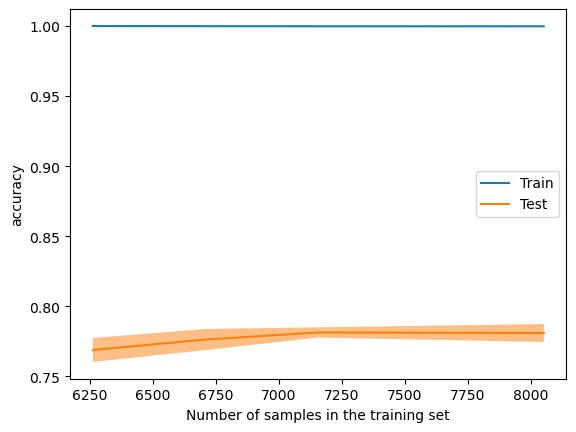

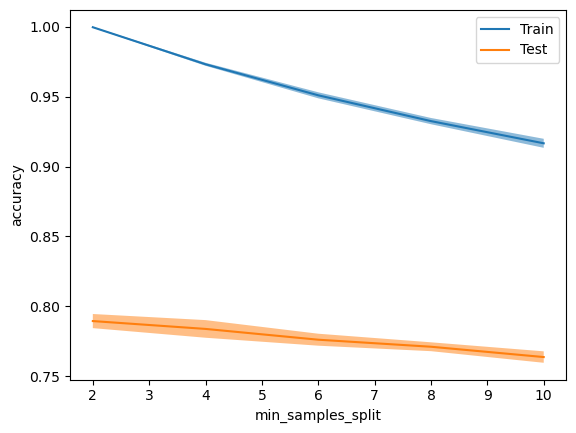

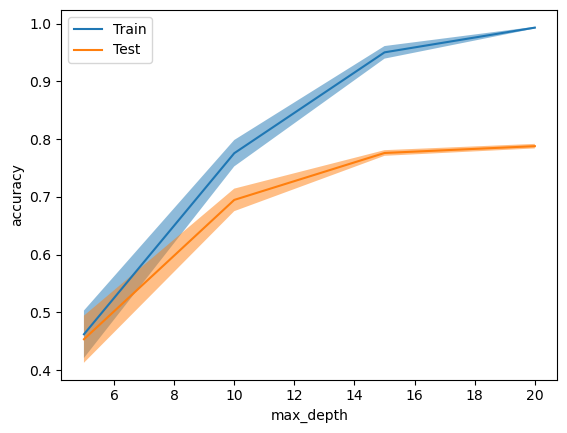

Working on: knn
LC (knn)
VC: Hyper 1 (n_neighbors)
VC: Hyper 2 (leaf_size)



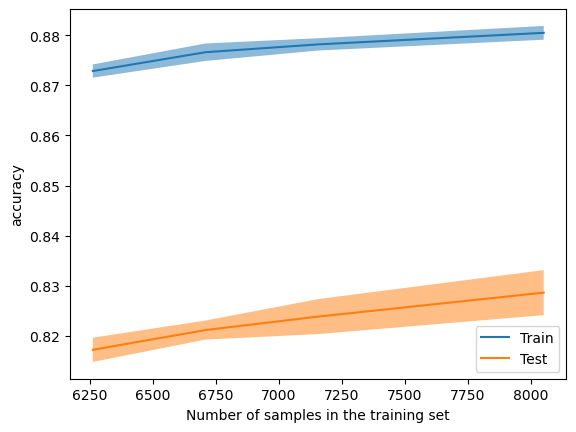

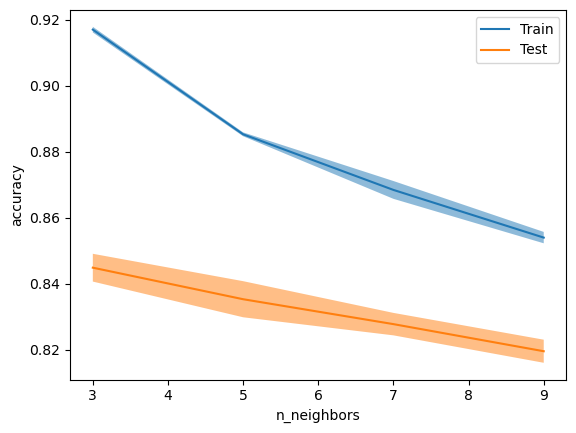

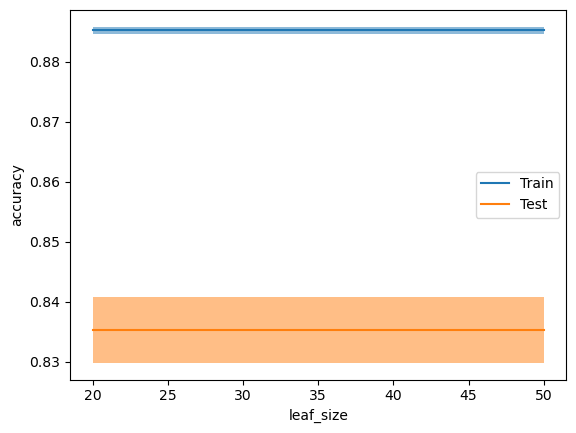

Working on: gradient boosting
LC (gradient boosting)
VC: Hyper 1 (n_estimators)
VC: Hyper 2 (subsample)



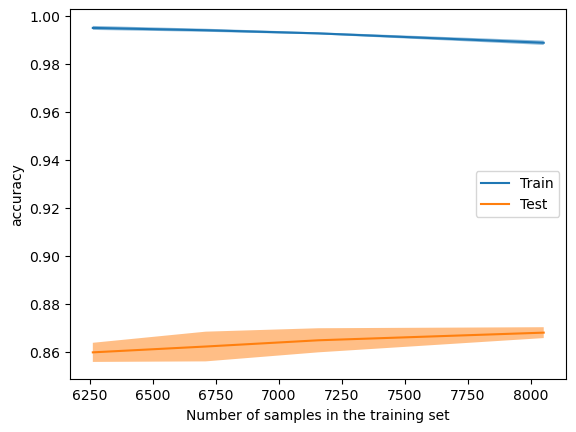

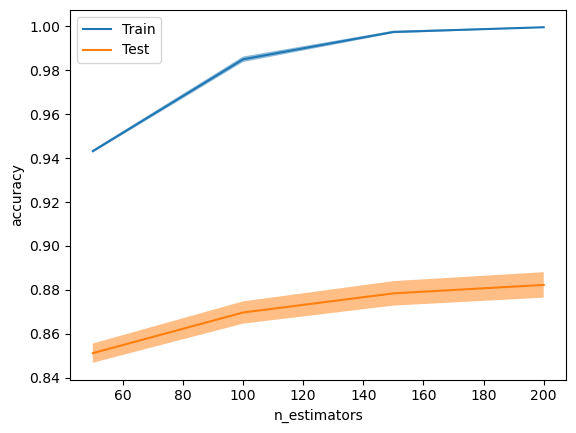

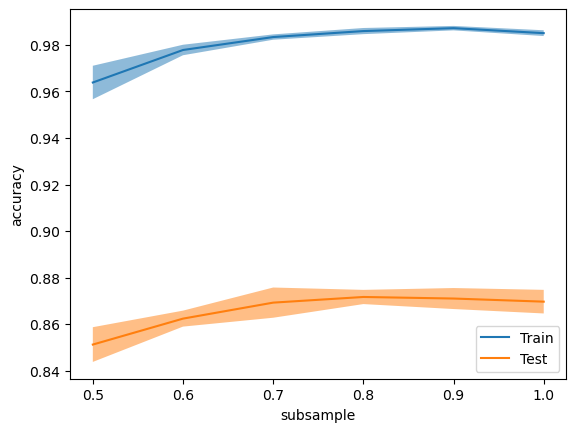

Working on: support vector machine
LC (support vector machine)
VC: Hyper 1 (C)
VC: Hyper 2 (gamma)



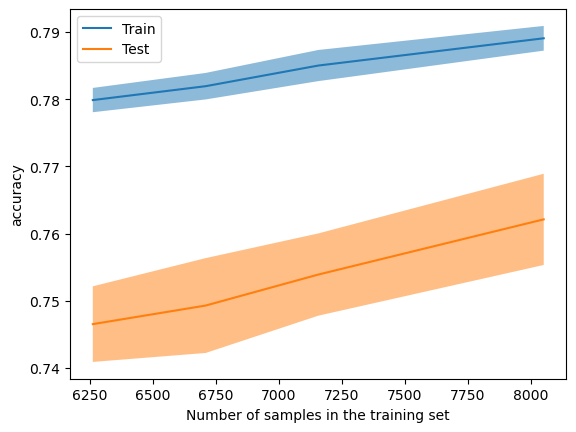

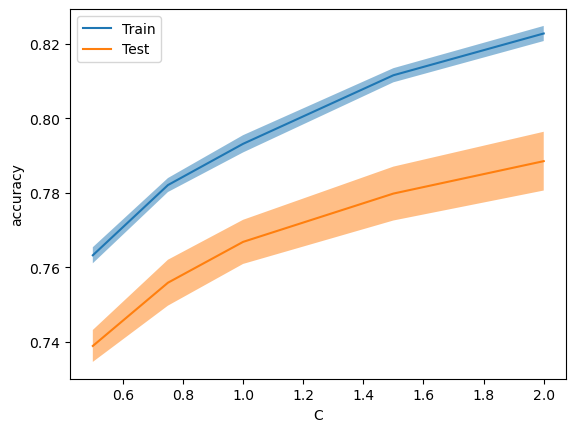

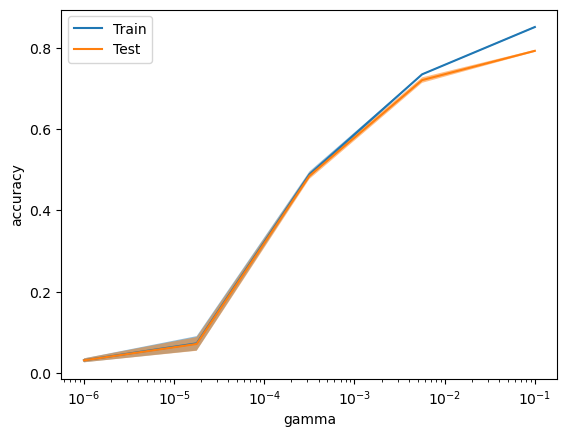

Working on: mlp
LC (mlp)
VC: Hyper 1 (max_iter)
VC: Hyper 2 (hidden_layer_sizes)



ValueError: 'x' is not 1-dimensional

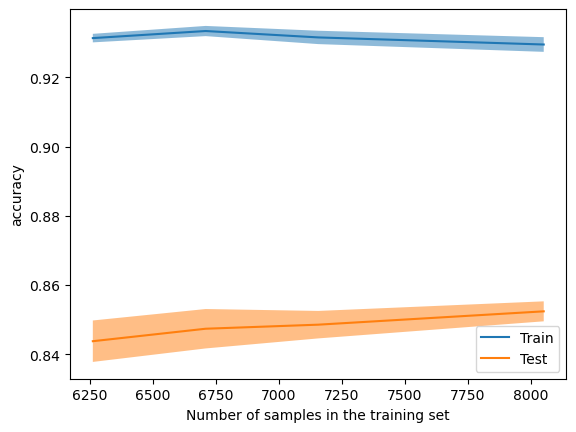

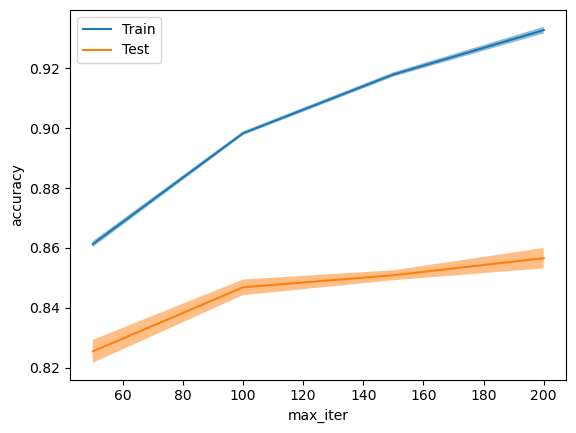

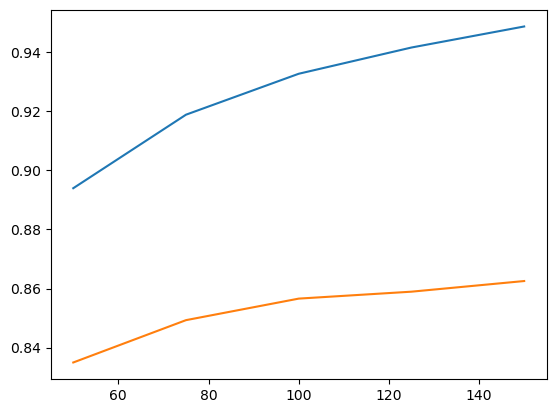

In [ ]:
for model_name in class_modelsNF.keys():
    print(f'Working on: {model_name}')
    
    LCtrain_sizes = class_modelsNF[model_name]['LCtrain_sizesnf']
    LCtrain_scores = class_modelsNF[model_name]['LCtrain_scoresnf']
    LCtest_scores = class_modelsNF[model_name]['LCtest_scoresnf']

    VCtrain_scores1 = class_modelsNF[model_name]['VCtrain_scores1nf']
    VCtest_scores1 = class_modelsNF[model_name]['VCtest_scores1nf']

    VCtrain_scores2 = class_modelsNF[model_name]['VCtrain_scores2nf']
    VCtest_scores2 = class_modelsNF[model_name]['VCtest_scores2nf']

    param1_name = nf_params[model_name]['param1_name']
    param1_range = nf_params[model_name]['param1_range']

    param2_name = nf_params[model_name]['param2_name']
    param2_range = nf_params[model_name]['param2_range']    

    LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                   train_scores=LCtrain_scores,
                                   test_scores=LCtest_scores,
                                   score_name="accuracy")

    VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                        param_range=param1_range,
                                        train_scores=VCtrain_scores1,
                                        test_scores=VCtest_scores1,
                                        score_name="accuracy")

    VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                        param_range=param2_range,
                                        train_scores=VCtrain_scores2,
                                        test_scores=VCtest_scores2,
                                        score_name="accuracy")
    print(f'LC ({model_name})')
    LCdisplay.plot()
    
    print(f'VC: Hyper 1 ({param1_name})')    
    VCdisplay1.plot()
    
    print(f'VC: Hyper 2 ({param2_name})\n')
    VCdisplay2.plot()

    plt.show()
    

#### Cardiovascular Disease

Working on: decision tree
LC (decision tree)
VC: Hyper 1 (min_samples_split)
VC: Hyper 2 (max_depth)


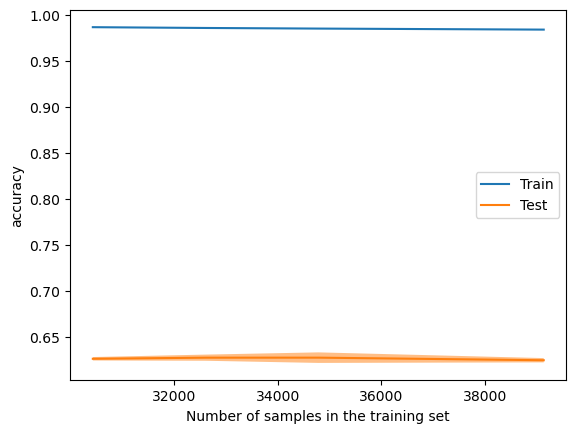

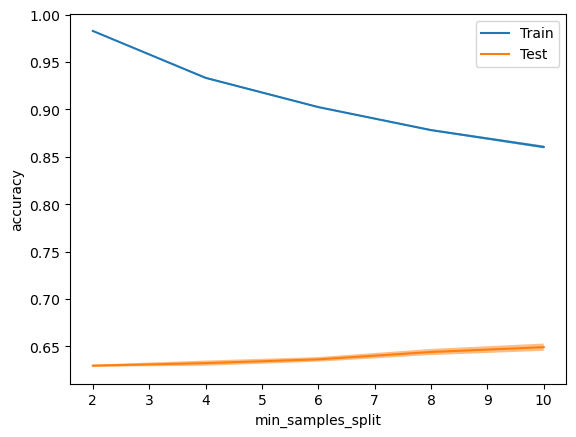

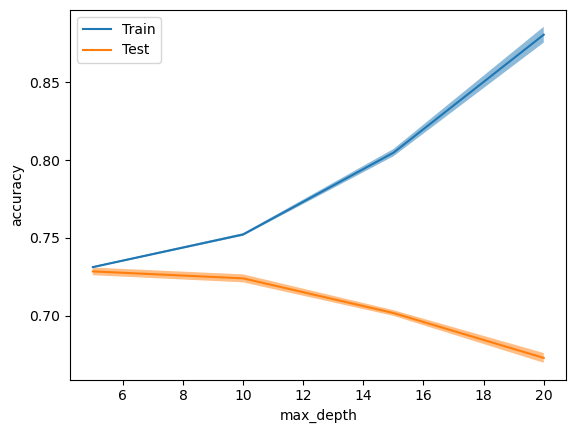

Working on: knn
LC (knn)
VC: Hyper 1 (n_neighbors)
VC: Hyper 2 (leaf_size)


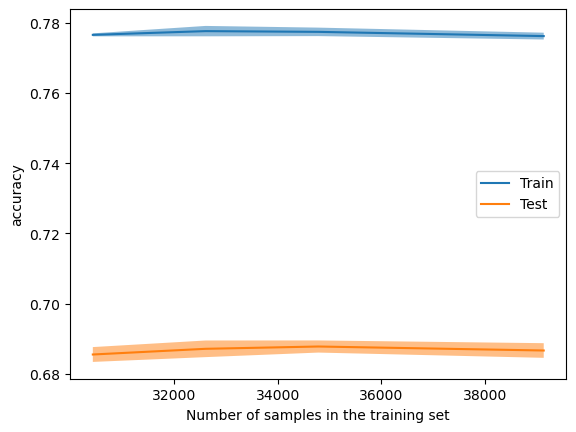

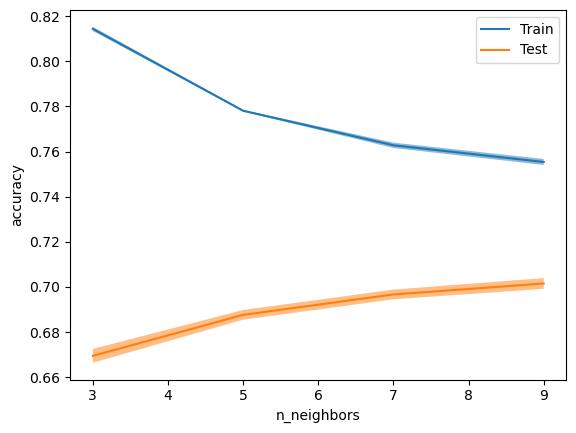

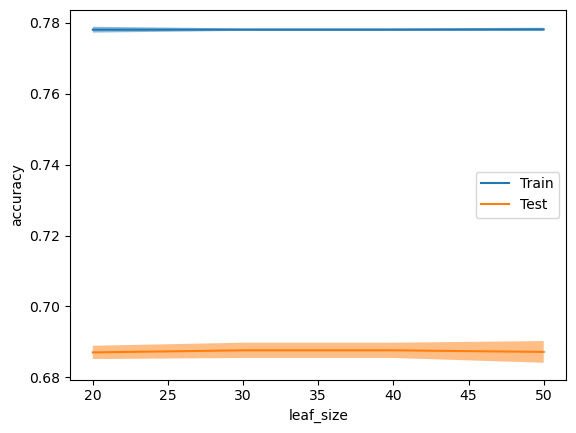

Working on: gradient boosting
LC (gradient boosting)
VC: Hyper 1 (n_estimators)
VC: Hyper 2 (subsample)


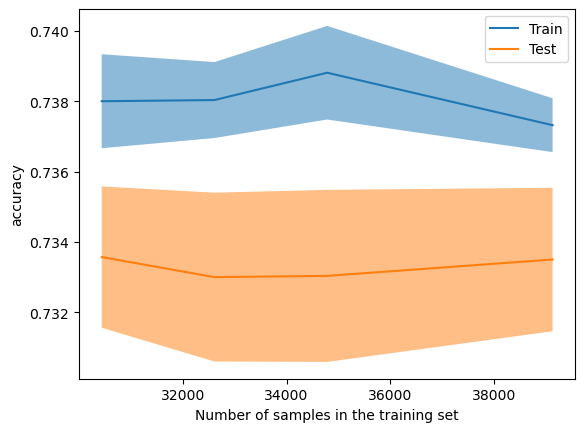

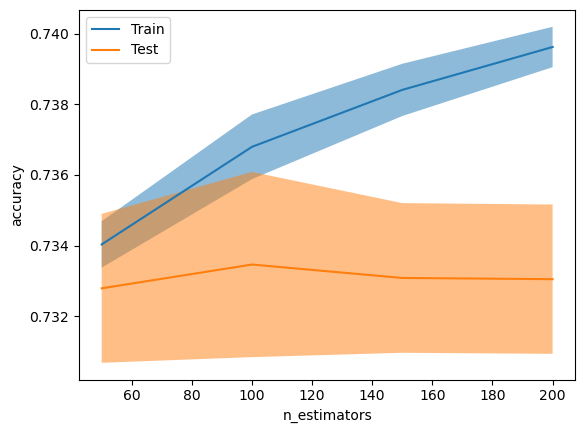

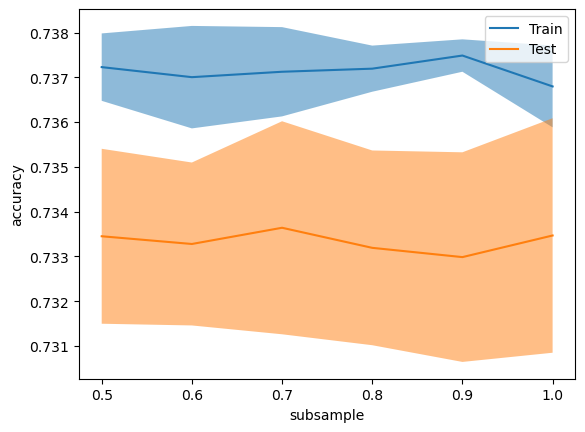

Working on: support vector machine
LC (support vector machine)
VC: Hyper 1 (C)
VC: Hyper 2 (gamma)


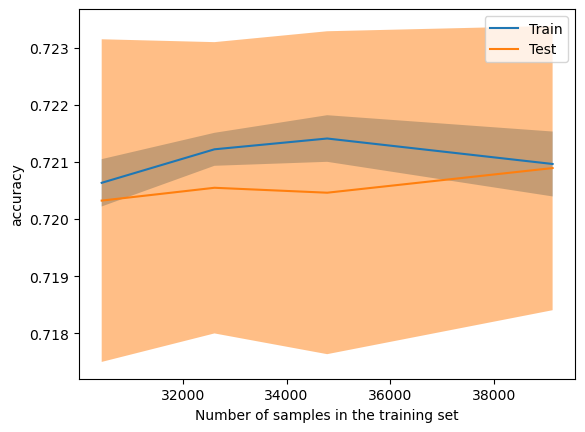

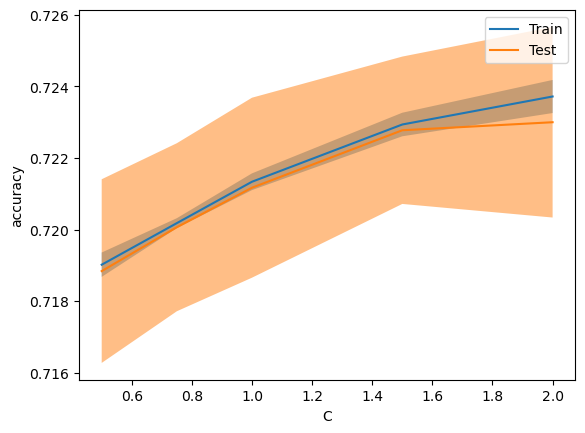

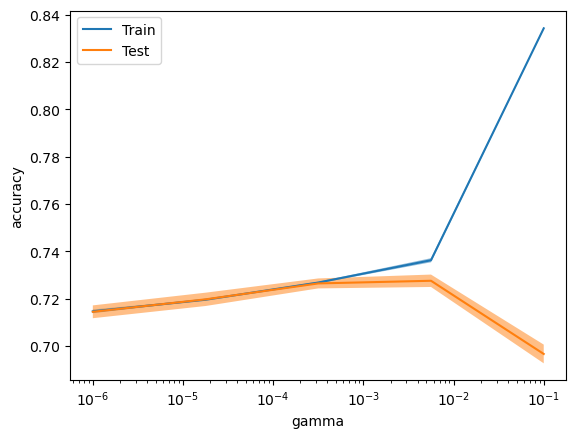

Working on: mlp


In [ ]:
for model_name in class_modelsCD.keys():
    print(f'Working on: {model_name}')

    LCtrain_sizes = class_modelsCD[model_name]['LCtrain_sizescd']
    LCtrain_scores = class_modelsCD[model_name]['LCtrain_scorescd']
    LCtest_scores = class_modelsCD[model_name]['LCtest_scorescd']

    VCtrain_scores1 = class_modelsCD[model_name]['VCtrain_scores1cd']
    VCtest_scores1 = class_modelsCD[model_name]['VCtest_scores1cd']

    VCtrain_scores2 = class_modelsCD[model_name]['VCtrain_scores2cd']
    VCtest_scores2 = class_modelsCD[model_name]['VCtest_scores2cd']

    param1_name = cd_params[model_name]['param1_name']
    param1_range = cd_params[model_name]['param1_range']

    param2_name = cd_params[model_name]['param2_name']
    param2_range = cd_params[model_name]['param2_range']    

    LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                   train_scores=LCtrain_scores,
                                   test_scores=LCtest_scores,
                                   score_name="accuracy")

    VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                        param_range=param1_range,
                                        train_scores=VCtrain_scores1,
                                        test_scores=VCtest_scores1,
                                        score_name="accuracy")

    VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                        param_range=param2_range,
                                        train_scores=VCtrain_scores2,
                                        test_scores=VCtest_scores2,
                                        score_name="accuracy")
    print(f'LC ({model_name})')
    LCdisplay.plot()
    
    print(f'VC: Hyper 1 ({param1_name})')
    VCdisplay1.plot()
    
    print(f'VC: Hyper 2 ({param2_name})')
    VCdisplay2.plot()

    plt.show()

#### Final Models: Nutrition Facts

In [ ]:
# y_train_pred = fitted_learning_curve.predict(X_train.values)
# y_test_prob = fitted_learning_curve.predict_proba(X_test.values)[:,1]
# y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

# metrics
# class_modelsNF[model_name]['Accuracy_train'] = accuracy_score(y_train_class, y_train_pred)
# class_modelsNF[model_name]['Accuracy_test'] = accuracy_score(y_test_class, y_test_pred)
# class_modelsNF[model_name]['Recall_train'] = recall_score(y_train_class, y_train_pred)
# class_modelsNF[model_name]['Recall_test'] = recall_score(y_test_class, y_test_pred)
# class_modelsNF[model_name]['precision_train'] = recall_score(y_train_class, y_train_pred)
# class_modelsNF[model_name]['precision_test'] = recall_score(y_test_class, y_test_pred)
# class_modelsNF[model_name]['F1_test'] = f1_score(y_test_class, y_test_pred)

#### Final Models: Cardiovascular Disease

In [ ]:
# y_train_pred = fitted_learning_curve.predict(X_train.values)
# y_test_prob = fitted_learning_curve.predict_proba(X_test.values)[:,1]
# y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

# metrics
# class_modelsCD[model_name]['Accuracy_train'] = accuracy_score(y_train_class, y_train_pred)
# class_modelsCD[model_name]['Accuracy_test'] = accuracy_score(y_test_class, y_test_pred)
# class_modelsCD[model_name]['Recall_train'] = recall_score(y_train_class, y_train_pred)
# class_modelsCD[model_name]['Recall_test'] = recall_score(y_test_class, y_test_pred)
# class_modelsCD[model_name]['precision_train'] = recall_score(y_train_class, y_train_pred)
# class_modelsCD[model_name]['precision_test'] = recall_score(y_test_class, y_test_pred)
# class_modelsCD[model_name]['F1_test'] = f1_score(y_test_class, y_test_pred)

#### Neural Network (PyTorch)

In [ ]:
# import copy

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import tqdm
# from sklearn.metrics import roc_curve
# from sklearn.model_selection import StratifiedKFold, train_test_split
# from sklearn.preprocessing import LabelEncoder

# # Read data
# data = pd.read_csv("sonar.csv", header=None)
# X = data.iloc[:, 0:60]
# y = data.iloc[:, 60]

# # Binary encoding of labels
# encoder = LabelEncoder()
# encoder.fit(y)
# y = encoder.transform(y)

# # Convert to 2D PyTorch tensors
# X = torch.tensor(X.values, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# # Define two models
# class Wide(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.hidden = nn.Linear(60, 180)
#         self.relu = nn.ReLU()
#         self.output = nn.Linear(180, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.relu(self.hidden(x))
#         x = self.sigmoid(self.output(x))
#         return x

# class Deep(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer1 = nn.Linear(60, 60)
#         self.act1 = nn.ReLU()
#         self.layer2 = nn.Linear(60, 60)
#         self.act2 = nn.ReLU()
#         self.layer3 = nn.Linear(60, 60)
#         self.act3 = nn.ReLU()
#         self.output = nn.Linear(60, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.act1(self.layer1(x))
#         x = self.act2(self.layer2(x))
#         x = self.act3(self.layer3(x))
#         x = self.sigmoid(self.output(x))
#         return x

# # Compare model sizes
# model1 = Wide()
# model2 = Deep()
# print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
# print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

# # Helper function to train one model
# def model_train(model, X_train, y_train, X_val, y_val):
#     # loss function and optimizer
#     loss_fn = nn.BCELoss()  # binary cross entropy
#     optimizer = optim.Adam(model.parameters(), lr=0.0001)

#     n_epochs = 300   # number of epochs to run
#     batch_size = 10  # size of each batch
#     batch_start = torch.arange(0, len(X_train), batch_size)

#     # Hold the best model
#     best_acc = - np.inf   # init to negative infinity
#     best_weights = None

#     for epoch in range(n_epochs):
#         model.train()
#         with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
#             bar.set_description(f"Epoch {epoch}")
#             for start in bar:
#                 # take a batch
#                 X_batch = X_train[start:start+batch_size]
#                 y_batch = y_train[start:start+batch_size]
#                 # forward pass
#                 y_pred = model(X_batch)
#                 loss = loss_fn(y_pred, y_batch)
#                 # backward pass
#                 optimizer.zero_grad()
#                 loss.backward()
#                 # update weights
#                 optimizer.step()
#                 # print progress
#                 acc = (y_pred.round() == y_batch).float().mean()
#                 bar.set_postfix(
#                     loss=float(loss),
#                     acc=float(acc)
#                 )
#         # evaluate accuracy at end of each epoch
#         model.eval()
#         y_pred = model(X_val)
#         acc = (y_pred.round() == y_val).float().mean()
#         acc = float(acc)
#         if acc > best_acc:
#             best_acc = acc
#             best_weights = copy.deepcopy(model.state_dict())
#     # restore model and return best accuracy
#     model.load_state_dict(best_weights)
#     return best_acc

# # train-test split: Hold out the test set for final model evaluation
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# # define 5-fold cross validation test harness
# kfold = StratifiedKFold(n_splits=5, shuffle=True)
# cv_scores_wide = []
# for train, test in kfold.split(X_train, y_train):
#     # create model, train, and get accuracy
#     model = Wide()
#     acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
#     print("Accuracy (wide): %.2f" % acc)
#     cv_scores_wide.append(acc)
# cv_scores_deep = []
# for train, test in kfold.split(X_train, y_train):
#     # create model, train, and get accuracy
#     model = Deep()
#     acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
#     print("Accuracy (deep): %.2f" % acc)
#     cv_scores_deep.append(acc)

# # evaluate the model
# wide_acc = np.mean(cv_scores_wide)
# wide_std = np.std(cv_scores_wide)
# deep_acc = np.mean(cv_scores_deep)
# deep_std = np.std(cv_scores_deep)
# print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
# print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

# # rebuild model with full set of training data
# if wide_acc > deep_acc:
#     print("Retrain a wide model")
#     model = Wide()
# else:
#     print("Retrain a deep model")
#     model = Deep()
# acc = model_train(model, X_train, y_train, X_test, y_test)
# print(f"Final model accuracy: {acc*100:.2f}%")

# model.eval()
# with torch.no_grad():
#     # Test out inference with 5 samples
#     for i in range(5):
#         y_pred = model(X_test[i:i+1])
#         print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

#     # Plot the ROC curve
#     y_pred = model(X_test)
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#     plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
#     plt.title("Receiver Operating Characteristics")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.show()

### LOGISTIC REGRESSION
# import torch
# import numpy as np
# from sklearn import datasets
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# nn = torch.nn

# # 0) prepare data
# bc = datasets.load_breast_cancer()
# x, y = bc.data, bc.target

# n_samples, n_features = x.shape
# print(n_samples, n_features)

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=1234)

# # scale
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# X_train = torch.from_numpy(X_train.astype(np.float32))
# X_test = torch.from_numpy(X_test.astype(np.float32))
# y_train = torch.from_numpy(y_train.astype(np.float32))
# y_test = torch.from_numpy(y_test.astype(np.float32))

# y_train = y_train.view(y_train.shape[0], 1)
# y_test = y_test.view(y_test.shape[0], 1)

# # 1) model
# # f = wx + b, sigmoid at the end
# class LogisticRegression(nn.Module):

#     def __init__(self, n_input_features):
#         super(LogisticRegression, self).__init__()
#         self.linear = nn.Linear(n_input_features, out_features=1)

#     def forward(self, x):
#         y_pred = torch.sigmoid(self.linear(x))
#         return y_pred

# model = LogisticRegression(n_features)

# # # 2) loss and optimizer
# lr = .01
# criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# # # 3) training loop
# n_epochs = 100
# for epoch in range(n_epochs):
#     # forward pass and loss
#     y_pred = model(X_train)
#     loss = criterion(y_pred, y_train)

#     # backward pass
#     loss.backward()

#     # update
#     optimizer.step()

#     # zero gradients
#     optimizer.zero_grad()

#     if (epoch + 1) % 10 == 0:
#         print(f"epoch: {epoch+1}, loss = {loss.item()}")


# with torch.no_grad():
#     y_predicted = model(X_test)
#     y_predicted_cls = y_predicted.round()
#     acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
#     print(f"accuracy = {acc}")